In [3]:
# packages and data imports 
import numpy as np 
import matplotlib.pyplot as plt
import urllib
import os  
from netCDF4 import Dataset
filelist=['miami_tower.npz','a17.nc','aircraft.npz']
data_download=True
if data_download:
    for the_file in filelist:
        url='http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}'.format(the_file)
        urllib.request.urlretrieve(url,the_file)
        print("download {}: size is {:6.2g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))


download miami_tower.npz: size is    1.5 Mbytes
download a17.nc: size is     17 Mbytes
download aircraft.npz: size is   0.73 Mbytes


In [4]:
# get a17.nc data - from the ubc_fft class 
with Dataset('a17.nc','r') as fin:
    data = fin.variables['tau'][...]
data = data - data.mean()
xdim = data.shape[0]
midpoint = int(np.floor(xdim/2))
scale = 0.025

# Problem -- lowpass filtering of a 2-d image

## part 1

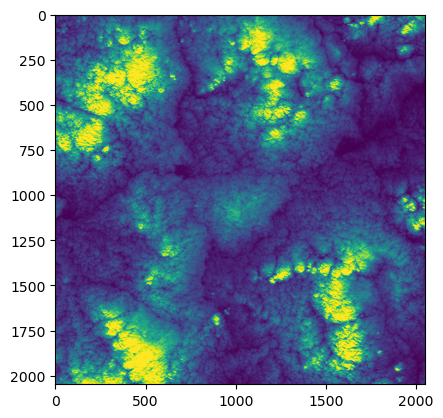

In [3]:
plt.imshow(data)

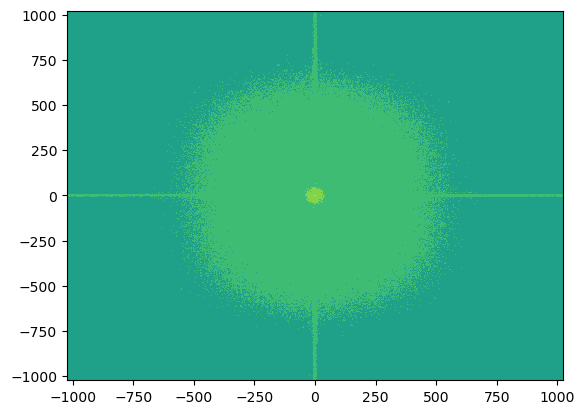

In [5]:
data_fft = np.fft.fft2(data)
freqx = np.arange(-1024,1024)
plt.contourf(freqx,freqx,np.log(np.fft.fftshift(abs(data_fft.real))))

In [19]:
N = int(data.shape[0]/2) # same for both since its square
nyq = 20
hzpbin = nyq/N
n = np.arange(0,40,hzpbin)
data_slice_x = data_fft[N,:].real 
data_slice_y = data_fft[:,N].real 

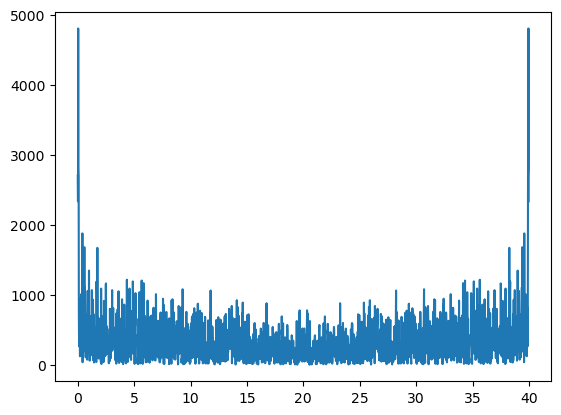

In [20]:
plt.plot(n,abs(data_slice_y))

In [7]:
N = int(data.shape[0])/2 # bins 
nyq = 20

hzpbin = nyq/N

In [18]:
n = np.arange(0,40,hzpbin)
n.size

2048